In [1174]:
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

%matplotlib inline

In [1175]:
# Read in average monthly temperature by state data
monthly_temps_path = 'Resources/average_monthly_temperature_by_state_1950-2022.csv'
monthly_temps_df = pd.read_csv(monthly_temps_path,
                               index_col='year')

In [1176]:
# The Adidas dataset only has the two years 2020 & 2021, Clean for the relevant years
monthly_temps_df = monthly_temps_df.loc['2020':'2021']

monthly_temps_df = monthly_temps_df.rename_axis('Year')

# Clean columns
monthly_temps_df.drop(['Unnamed: 0', 'monthly_mean_from_1901_to_2000', 'centroid_lon', 'centroid_lat'], axis=1, inplace=True)

monthly_temps_df = monthly_temps_df.rename(
    columns={
        'month': 'Month',
        'state': 'State',
        'average_temp': 'Average Temp'
    }
)

In [1177]:
monthly_temps_df.head()

,Month,State,Average Temp
Year,,,
2020,1,Alabama,50.4
2020,1,Arizona,43.0
2020,1,Arkansas,44.8
2020,1,California,44.8
2020,1,Colorado,27.8


In [1178]:
# Resetting index to prep 'Year' for datetime type conversion
monthly_temps_df = monthly_temps_df.reset_index()

In [1179]:
# Merging Year and Month columns as a datetime dtype
monthly_temps_df['Date'] = pd.to_datetime(monthly_temps_df['Year'].astype(str) + '-' + monthly_temps_df['Month'].astype(str).str.zfill(2))

# Dropping the irrelevent 'Days' as they all show as xx-xx-01
monthly_temps_df['Date'] = monthly_temps_df['Date'].dt.to_period('M')

# Setting index to the new datetime 'Date' column
monthly_temps_df = monthly_temps_df.set_index('Date')

# Dropping the now irrelevant duplicate columns
monthly_temps_df.drop(['Year', 'Month'], axis=1, inplace=True)


In [1180]:
# Check the dtype conversion is correct
monthly_temps_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1152 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   State         1152 non-null   object 
 1   Average Temp  1152 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.0+ KB


In [1181]:
# Check the formatting is correct
display(monthly_temps_df.head(10))
display(monthly_temps_df.tail(10))

,State,Average Temp
Date,,
2020-01,Alabama,50.4
2020-01,Arizona,43.0
2020-01,Arkansas,44.8
2020-01,California,44.8
2020-01,Colorado,27.8
2020-01,Connecticut,32.4
2020-01,Delaware,40.1
2020-01,Florida,62.8
2020-01,Georgia,51.8


,State,Average Temp
Date,,
2021-12,South Dakota,31.4
2021-12,Tennessee,48.0
2021-12,Texas,58.2
2021-12,Utah,36.8
2021-12,Vermont,31.2
2021-12,Virginia,45.2
2021-12,Washington,34.7
2021-12,West Virginia,41.8
2021-12,Wisconsin,29.3


In [1182]:
# Groupby State, Year, and Month to sort
monthly_temps_by_state = monthly_temps_df.groupby(['State', monthly_temps_df.index.year, monthly_temps_df.index.month])['Average Temp'].sum()

display(monthly_temps_by_state.head(10))
display(monthly_temps_by_state.tail(10))

State    Date  Date
Alabama  2020  1       50.4
               2       50.2
               3       57.2
               4       62.8
               5       65.4
               6       72.9
               7       78.9
               8       80.6
               9       77.2
               10      70.6
Name: Average Temp, dtype: float64

State    Date  Date
Wyoming  2021  3       24.8
               4       35.0
               5       43.4
               6       56.8
               7       67.4
               8       67.1
               9       61.1
               10      51.0
               11      40.2
               12      31.3
Name: Average Temp, dtype: float64

In [1183]:
# Rename the Indexes
monthly_temps_by_state.index.names = ['State', 'Year', 'Month']

monthly_temps_by_state.head()

State    Year  Month
Alabama  2020  1        50.4
               2        50.2
               3        57.2
               4        62.8
               5        65.4
Name: Average Temp, dtype: float64

In [1184]:
# Save Cleaned temperature data csv
monthly_temps_by_state.to_csv('Resources/avg_temps_cleaned.csv')


In [1185]:
# Read in the Adidas xlsx
adidas_path = 'Resources/Adidas US Sales Datasets.xlsx'
adidas_df = pd.read_excel(adidas_path,
                          index_col='Unnamed: 3',
                          parse_dates=True,
                          date_format='dateutil')


In [1186]:
# See what we're dealing with
adidas_df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
NaN,NaN,NaN,Adidas Sales Database,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Invoice Date,NaN,Retailer,Retailer ID,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
2020-01-01 00:00:00,NaN,Foot Locker,1185732,Northeast,New York,New York,Men's Street Footwear,50,1200,600000,300000,0.5,In-store


In [1187]:
adidas_df['Unnamed: 4'].unique()

array([nan, 'Region', 'Northeast', 'South', 'West', 'Midwest',
       'Southeast'], dtype=object)

In [1188]:
# Clean for relevent data to include Region, State, Product, Price per Unit, Units Sold, and Total Sales

adidas_df = adidas_df.rename_axis('Invoice Date')
adidas_df.drop(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], axis=1, inplace=True)
adidas_df = adidas_df.rename(
    columns={
        'Unnamed: 4': 'Region',
        'Unnamed: 5': 'State',
        'Unnamed: 7': 'Product',
        'Unnamed: 8': 'Price per Unit',
        'Unnamed: 9': 'Units Sold',
        'Unnamed: 10': 'Total Sales',
    }
)

# Drop NaNs
adidas_df.dropna(inplace=True)

In [1189]:
# Reset index to prep for datetime conversion
adidas_df = adidas_df.reset_index()

# The first row seems to be all strings leftover from xcels column format, dropping that
adidas_df.drop(0, axis=0, inplace=True)

# Coverting invoice date column to datetime
adidas_df['Date'] = pd.to_datetime(adidas_df['Invoice Date'])

# Setting the datetime column to the index
adidas_df = adidas_df.set_index('Date')

# Dropping the now irrelevant duplicate column
adidas_df.drop('Invoice Date', axis=1, inplace=True)

# Sorting the dates
adidas_df = adidas_df.sort_index()

display(adidas_df.head(10))
display(adidas_df.tail(10))

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2020-01-01,Northeast,New York,Men's Street Footwear,50,1200,600000
2020-01-01,Northeast,Pennsylvania,Women's Apparel,75,275,206250
2020-01-01,Northeast,Pennsylvania,Women's Apparel,53,83,4399
2020-01-01,Northeast,New York,Men's Street Footwear,47,336,15792
2020-01-01,Northeast,New York,Men's Street Footwear,34,384,13056
2020-01-01,Northeast,Pennsylvania,Women's Apparel,68,83,5644
2020-01-02,Northeast,Pennsylvania,Men's Street Footwear,32,122,3904
2020-01-02,Northeast,Pennsylvania,Men's Street Footwear,27,158,4266
2020-01-02,Northeast,New York,Men's Athletic Footwear,36,320,11520


,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2021-12-30,Northeast,Pennsylvania,Women's Athletic Footwear,60.0,175,105000.0
2021-12-30,Northeast,Pennsylvania,Women's Athletic Footwear,57,53,3021
2021-12-30,Northeast,Maine,Women's Athletic Footwear,42,36,1512
2021-12-30,Northeast,Pennsylvania,Women's Athletic Footwear,40,53,2120
2021-12-30,Northeast,Maine,Women's Athletic Footwear,45,125,56250
2021-12-31,Northeast,Pennsylvania,Men's Apparel,70,175,122500
2021-12-31,Northeast,Pennsylvania,Men's Apparel,63,47,2961
2021-12-31,Northeast,Pennsylvania,Men's Apparel,46,56,2576
2021-12-31,Northeast,Maine,Men's Apparel,52,36,1872


In [1190]:
adidas_region = adidas_df.sort_values('Region')

display(adidas_region.head(30))
display(adidas_region.tail(30))

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2021-08-13,Midwest,Kansas,Women's Athletic Footwear,37,90,3330
2021-01-10,Midwest,Wisconsin,Women's Apparel,32,84,2688
2021-09-07,Midwest,Iowa,Women's Apparel,40,225,90000
2021-09-07,Midwest,Iowa,Women's Apparel,36,61,2196
2021-06-17,Midwest,Illinois,Women's Apparel,50,225,112500
2021-06-17,Midwest,Michigan,Women's Apparel,65,675,438750
2021-06-17,Midwest,Michigan,Women's Athletic Footwear,45,525,236250
2021-01-10,Midwest,Wisconsin,Men's Apparel,41,58,2378
2021-01-10,Midwest,Wisconsin,Men's Athletic Footwear,32,78,2496


,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2021-09-12,West,Utah,Women's Athletic Footwear,7,111,777
2021-09-12,West,Utah,Women's Apparel,18,132,2376
2021-09-12,West,Utah,Men's Athletic Footwear,23,122,2806
2021-09-12,West,Utah,Women's Street Footwear,7,105,735
2021-01-09,West,California,Women's Athletic Footwear,59,210,12390
2021-01-09,West,California,Women's Athletic Footwear,41,224,9184
2021-05-20,West,Alaska,Men's Apparel,62,69,4278
2021-09-11,West,Hawaii,Women's Apparel,56,105,5880
2021-09-11,West,Hawaii,Women's Athletic Footwear,62,85,5270


In [1191]:
adidas_df = adidas_df.reset_index()
adidas_df['Date'] = adidas_df['Date'].dt.to_period('M')

adidas_df = adidas_df.set_index('Date')
adidas_df.head(10)

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2020-01,Northeast,New York,Men's Street Footwear,50,1200,600000
2020-01,Northeast,Pennsylvania,Women's Apparel,75,275,206250
2020-01,Northeast,Pennsylvania,Women's Apparel,53,83,4399
2020-01,Northeast,New York,Men's Street Footwear,47,336,15792
2020-01,Northeast,New York,Men's Street Footwear,34,384,13056
2020-01,Northeast,Pennsylvania,Women's Apparel,68,83,5644
2020-01,Northeast,Pennsylvania,Men's Street Footwear,32,122,3904
2020-01,Northeast,Pennsylvania,Men's Street Footwear,27,158,4266
2020-01,Northeast,New York,Men's Athletic Footwear,36,320,11520


In [1192]:
# checking dtypes
adidas_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 9648 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Region          9648 non-null   object
 1   State           9648 non-null   object
 2   Product         9648 non-null   object
 3   Price per Unit  9648 non-null   object
 4   Units Sold      9648 non-null   object
 5   Total Sales     9648 non-null   object
dtypes: object(6)
memory usage: 527.6+ KB


In [1193]:
# Convert columns to dtype 'int' where needed
adidas_df[['Price per Unit', 'Units Sold', 'Total Sales']] = adidas_df[['Price per Unit', 'Units Sold', 'Total Sales']].astype(int)

adidas_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 9648 entries, 2020-01 to 2021-12
Freq: M
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Region          9648 non-null   object
 1   State           9648 non-null   object
 2   Product         9648 non-null   object
 3   Price per Unit  9648 non-null   int32 
 4   Units Sold      9648 non-null   int32 
 5   Total Sales     9648 non-null   int32 
dtypes: int32(3), object(3)
memory usage: 414.6+ KB


In [1194]:
adidas_df['Total Sales'] = adidas_df['Price per Unit'] * adidas_df['Units Sold']

adidas_df.head()

,Region,State,Product,Price per Unit,Units Sold,Total Sales
Date,,,,,,
2020-01,Northeast,New York,Men's Street Footwear,50,1200,60000
2020-01,Northeast,Pennsylvania,Women's Apparel,75,275,20625
2020-01,Northeast,Pennsylvania,Women's Apparel,53,83,4399
2020-01,Northeast,New York,Men's Street Footwear,47,336,15792
2020-01,Northeast,New York,Men's Street Footwear,34,384,13056


In [1195]:
adidas_df['Product'].unique()

array(["Men's Street Footwear", "Women's Apparel",
       "Men's Athletic Footwear", "Women's Street Footwear",
       "Women's Athletic Footwear", "Men's Apparel"], dtype=object)

In [1196]:
adidas_by_month = adidas_df.groupby(['State', adidas_df.index.year, adidas_df.index.month,'Region', 'Product'])[['Price per Unit', 'Units Sold', 'Total Sales']].sum()
adidas_by_month = pd.DataFrame(adidas_by_month)
adidas_by_month.head(20)

Price per Unit  \
State   Date Date Region Product                                     
Alabama 2021 8    South  Men's Apparel                         525   
                         Men's Athletic Footwear               312   
                         Men's Street Footwear                 343   
                         Women's Apparel                       459   
                         Women's Athletic Footwear             330   
                         Women's Street Footwear               249   
             9    South  Men's Apparel                         616   
                         Men's Athletic Footwear               639   
                         Men's Street Footwear                 500   
                         Women's Apparel                       667   
                         Women's Athletic Footwear             630   
                         Women's Street Footwear               640   
             10   South  Men's Apparel                         292   
                         Men's Athletic Footwear               319   
                         Men's Street Footwear                 267   
                         Women's Apparel                       355   
                         Women's Athletic Footwear             399   
                         Women's Street Footwear               378   
Alaska  2021 1    West   Men's Apparel                          96   
                         Men's Athletic Footwear                88   

                                                    Units Sold  Total Sales  
State   Date Date Region Product                                             
Alabama 2021 8    South  Men's Apparel                    2430        91281  
                         Men's Athletic Footwear          4146       111112  
                         Men's Street Footwear            5334       129295  
                         Women's Apparel                  4189       137378  
                         Women's Athletic Footwear        2561        75010  
                         Women's Street Footwear          3084        64769  
             9    South  Men's Apparel                    3370       149180  
                         Men's Athletic Footwear          5431       247776  
                         Men's Street Footwear            5323       191497  
                         Women's Apparel                  5460       265670  
                         Women's Athletic Footwear        3682       161302  
                         Women's Street Footwear          5880       267548  
             10   South  Men's Apparel                    1485        76276  
                         Men's Athletic Footwear          2655       103471  
                         Men's Street Footwear            1955        96814  
                         Women's Apparel                  2179       135392  
                         Women's Athletic Footwear        1760        90871  
                         Women's Street Footwear          2403       116607  
Alaska  2021 1    West   Men's Apparel                     221        10866  
                         Men's Athletic Footwear           484        21562

In [1197]:
adidas_by_month.index.names = ['State', 'Year', 'Month', 'Region', 'Product']

In [1198]:
adidas_by_month = adidas_by_month.reset_index()

def gender(x):
    if 'Wo' in x:
        return "Women's"
    else:
        return "Men's"
    
adidas_by_month['Gender'] = adidas_by_month['Product'].apply(gender)

def subcategory(x):
    if 'Apparel' in x:
        return 'Apparel'
    elif 'Athletic' in x:
        return "Athletic Footwear"
    else:
        return "Street Footwear"
    
adidas_by_month['Subcategory'] = adidas_by_month['Product'].apply(subcategory)

display(adidas_by_month.head())
display(adidas_by_month.tail())

,State,Year,Month,Region,Product,Price per Unit,Units Sold,Total Sales,Gender,Subcategory
0,Alabama,2021,8,South,Men's Apparel,525,2430,91281,Men's,Apparel
1,Alabama,2021,8,South,Men's Athletic Footwear,312,4146,111112,Men's,Athletic Footwear
2,Alabama,2021,8,South,Men's Street Footwear,343,5334,129295,Men's,Street Footwear
3,Alabama,2021,8,South,Women's Apparel,459,4189,137378,Women's,Apparel
4,Alabama,2021,8,South,Women's Athletic Footwear,330,2561,75010,Women's,Athletic Footwear


,State,Year,Month,Region,Product,Price per Unit,Units Sold,Total Sales,Gender,Subcategory
3025,Wyoming,2021,12,West,Men's Athletic Footwear,89,768,34392,Men's,Athletic Footwear
3026,Wyoming,2021,12,West,Men's Street Footwear,107,1024,55648,Men's,Street Footwear
3027,Wyoming,2021,12,West,Women's Apparel,116,774,45744,Women's,Apparel
3028,Wyoming,2021,12,West,Women's Athletic Footwear,89,635,28440,Women's,Athletic Footwear
3029,Wyoming,2021,12,West,Women's Street Footwear,89,715,32010,Women's,Street Footwear


In [1199]:
adidas_athletic_footwear = adidas_by_month[adidas_by_month['Subcategory'].str.contains('Athletic')]
display(adidas_athletic_footwear.head())
display(adidas_athletic_footwear.tail())
adidas_athletic_footwear['Subcategory'].unique()

,State,Year,Month,Region,Product,Price per Unit,Units Sold,Total Sales,Gender,Subcategory
1,Alabama,2021,8,South,Men's Athletic Footwear,312,4146,111112,Men's,Athletic Footwear
4,Alabama,2021,8,South,Women's Athletic Footwear,330,2561,75010,Women's,Athletic Footwear
7,Alabama,2021,9,South,Men's Athletic Footwear,639,5431,247776,Men's,Athletic Footwear
10,Alabama,2021,9,South,Women's Athletic Footwear,630,3682,161302,Women's,Athletic Footwear
13,Alabama,2021,10,South,Men's Athletic Footwear,319,2655,103471,Men's,Athletic Footwear


,State,Year,Month,Region,Product,Price per Unit,Units Sold,Total Sales,Gender,Subcategory
3016,Wyoming,2021,10,West,Women's Athletic Footwear,86,594,26254,Women's,Athletic Footwear
3019,Wyoming,2021,11,West,Men's Athletic Footwear,87,742,32889,Men's,Athletic Footwear
3022,Wyoming,2021,11,West,Women's Athletic Footwear,87,635,28170,Women's,Athletic Footwear
3025,Wyoming,2021,12,West,Men's Athletic Footwear,89,768,34392,Men's,Athletic Footwear
3028,Wyoming,2021,12,West,Women's Athletic Footwear,89,635,28440,Women's,Athletic Footwear


array(['Athletic Footwear'], dtype=object)

In [1200]:
adidas_athletic_footwear = adidas_athletic_footwear.groupby(['State', 'Year', 'Month', 'Region', 'Gender', 'Subcategory'])[['Price per Unit', 'Units Sold', 'Total Sales']].sum()
adidas_athletic_footwear = pd.DataFrame(adidas_athletic_footwear)
display(adidas_athletic_footwear.head(10))
display(adidas_athletic_footwear.tail(10))

Price per Unit  \
State   Year Month Region Gender  Subcategory                         
Alabama 2021 8     South  Men's   Athletic Footwear             312   
                          Women's Athletic Footwear             330   
             9     South  Men's   Athletic Footwear             639   
                          Women's Athletic Footwear             630   
             10    South  Men's   Athletic Footwear             319   
                          Women's Athletic Footwear             399   
Alaska  2021 1     West   Men's   Athletic Footwear              88   
                          Women's Athletic Footwear              88   
             2     West   Men's   Athletic Footwear             195   
                          Women's Athletic Footwear              98   

                                                     Units Sold  Total Sales  
State   Year Month Region Gender  Subcategory                                 
Alabama 2021 8     South  Men's   Athletic Footwear        4146       111112  
                          Women's Athletic Footwear        2561        75010  
             9     South  Men's   Athletic Footwear        5431       247776  
                          Women's Athletic Footwear        3682       161302  
             10    South  Men's   Athletic Footwear        2655       103471  
                          Women's Athletic Footwear        1760        90871  
Alaska  2021 1     West   Men's   Athletic Footwear         484        21562  
                          Women's Athletic Footwear         281        12533  
             2     West   Men's   Athletic Footwear         763        36811  
                          Women's Athletic Footwear         221        10829

Price per Unit  \
State   Year Month Region Gender  Subcategory                         
Wyoming 2021 8     West   Men's   Athletic Footwear              88   
                          Women's Athletic Footwear              78   
             9     West   Men's   Athletic Footwear              89   
                          Women's Athletic Footwear              78   
             10    West   Men's   Athletic Footwear              89   
                          Women's Athletic Footwear              86   
             11    West   Men's   Athletic Footwear              87   
                          Women's Athletic Footwear              87   
             12    West   Men's   Athletic Footwear              89   
                          Women's Athletic Footwear              89   

                                                     Units Sold  Total Sales  
State   Year Month Region Gender  Subcategory                                 
Wyoming 2021 8     West   Men's   Athletic Footwear         788        35134  
                          Women's Athletic Footwear         672        26586  
             9     West   Men's   Athletic Footwear         750        33600  
                          Women's Athletic Footwear         635        25130  
             10    West   Men's   Athletic Footwear         774        34656  
                          Women's Athletic Footwear         594        26254  
             11    West   Men's   Athletic Footwear         742        32889  
                          Women's Athletic Footwear         635        28170  
             12    West   Men's   Athletic Footwear         768        34392  
                          Women's Athletic Footwear         635        28440

In [1201]:
adidas_athletic_footwear = adidas_athletic_footwear.reset_index()

adidas_athletic_footwear = adidas_athletic_footwear.set_index(['State', 'Year'])

adidas_athletic_footwear.head()

Month Region   Gender        Subcategory  Price per Unit  \
State   Year                                                             
Alabama 2021      8  South    Men's  Athletic Footwear             312   
        2021      8  South  Women's  Athletic Footwear             330   
        2021      9  South    Men's  Athletic Footwear             639   
        2021      9  South  Women's  Athletic Footwear             630   
        2021     10  South    Men's  Athletic Footwear             319   

              Units Sold  Total Sales  
State   Year                           
Alabama 2021        4146       111112  
        2021        2561        75010  
        2021        5431       247776  
        2021        3682       161302  
        2021        2655       103471

In [1202]:
adidas_mens_athletic_footwear = adidas_athletic_footwear[adidas_athletic_footwear['Gender'].str.match("Men's")]
adidas_mens_athletic_footwear.head()

Month Region Gender        Subcategory  Price per Unit  \
State   Year                                                           
Alabama 2021      8  South  Men's  Athletic Footwear             312   
        2021      9  South  Men's  Athletic Footwear             639   
        2021     10  South  Men's  Athletic Footwear             319   
Alaska  2021      1   West  Men's  Athletic Footwear              88   
        2021      2   West  Men's  Athletic Footwear             195   

              Units Sold  Total Sales  
State   Year                           
Alabama 2021        4146       111112  
        2021        5431       247776  
        2021        2655       103471  
Alaska  2021         484        21562  
        2021         763        36811

In [1203]:
adidas_mens_athletic_footwear = adidas_mens_athletic_footwear.groupby(['State', 'Year', 'Month'])[['Price per Unit', 'Units Sold', 'Total Sales']].sum()
adidas_mens_athletic_footwear= adidas_mens_athletic_footwear.rename(
    columns={
        'Price per Unit': '(M)Price per Unit',
        'Units Sold': '(M)Units Sold',
        'Total Sales': "Men's Athletic Footwear Sales"})
adidas_mens_athletic_footwear.head()

(M)Price per Unit  (M)Units Sold  \
State   Year Month                                     
Alabama 2021 8                    312           4146   
             9                    639           5431   
             10                   319           2655   
Alaska  2021 1                     88            484   
             2                    195            763   

                    Men's Athletic Footwear Sales  
State   Year Month                                 
Alabama 2021 8                             111112  
             9                             247776  
             10                            103471  
Alaska  2021 1                              21562  
             2                              36811

In [1204]:
adidas_womens_athletic_footwear = adidas_athletic_footwear[adidas_athletic_footwear['Gender'].str.match("Women's")]
adidas_womens_athletic_footwear.head()

Month Region   Gender        Subcategory  Price per Unit  \
State   Year                                                             
Alabama 2021      8  South  Women's  Athletic Footwear             330   
        2021      9  South  Women's  Athletic Footwear             630   
        2021     10  South  Women's  Athletic Footwear             399   
Alaska  2021      1   West  Women's  Athletic Footwear              88   
        2021      2   West  Women's  Athletic Footwear              98   

              Units Sold  Total Sales  
State   Year                           
Alabama 2021        2561        75010  
        2021        3682       161302  
        2021        1760        90871  
Alaska  2021         281        12533  
        2021         221        10829

In [1205]:
adidas_womens_athletic_footwear = adidas_womens_athletic_footwear.groupby(['State', 'Year', 'Month'])[['Price per Unit', 'Units Sold', 'Total Sales']].sum()
adidas_womens_athletic_footwear= adidas_womens_athletic_footwear.rename(
    columns={
        'Price per Unit': '(W)Price per Unit',
        'Units Sold': '(W)Units Sold',
        'Total Sales': "Women's Athletic Footwear Sales"})
adidas_womens_athletic_footwear.head()

(W)Price per Unit  (W)Units Sold  \
State   Year Month                                     
Alabama 2021 8                    330           2561   
             9                    630           3682   
             10                   399           1760   
Alaska  2021 1                     88            281   
             2                     98            221   

                    Women's Athletic Footwear Sales  
State   Year Month                                   
Alabama 2021 8                                75010  
             9                               161302  
             10                               90871  
Alaska  2021 1                                12533  
             2                                10829

In [1206]:
monthly_temps_by_state = monthly_temps_by_state.reset_index()



monthly_temps_by_state = monthly_temps_by_state.groupby(['State', 'Year', 'Month'])['Average Temp'].sum()

monthly_temps_by_state.head()

State    Year  Month
Alabama  2020  1        50.4
               2        50.2
               3        57.2
               4        62.8
               5        65.4
Name: Average Temp, dtype: float64

In [1207]:
adidas_monthly_sales = adidas_df['Total Sales'].groupby(by=[adidas_df.index.year, adidas_df.index.month]).sum()

print(adidas_monthly_sales)

Date  Date
2020  1        2311271
      2        2140813
      3        2473102
      4        3192731
      5        2164764
      6        1083069
      7        2182388
      8        2641630
      9        2367686
      10       1428269
      11       1167975
      12       1077277
2021  1        7428996
      2        6117190
      3        5213682
      4        6490789
      5        8557211
      6        8703453
      7       10357931
      8        9642846
      9        8032173
      10       7101389
      11       7846245
      12      10326930
Name: Total Sales, dtype: int32


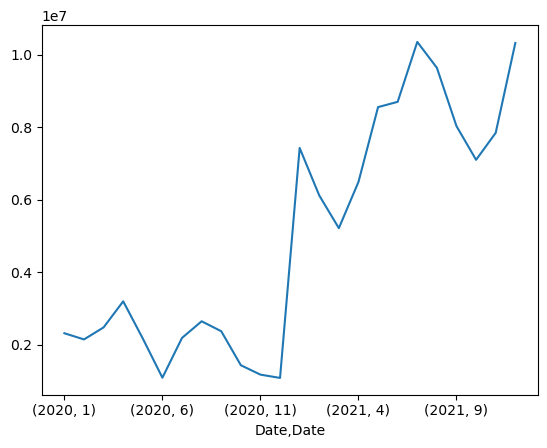

In [1208]:
adidas_monthly_sales.plot()
pyplot.show()

In [1209]:
adidas_monthly_sales_by_state = adidas_df.groupby(['State', adidas_df.index.year, adidas_df.index.month])['Total Sales'].sum()



print(adidas_monthly_sales_by_state)

State    Date  Date
Alabama  2021  8        608845
               9       1282973
               10       619431
Alaska   2021  1        128350
               2        191433
                        ...   
Wyoming  2021  8        222536
               9        207968
               10       218672
               11       220168
               12       231564
Name: Total Sales, Length: 509, dtype: int32


In [1210]:
adidas_monthly_sales_by_state.info()

<class 'pandas.core.series.Series'>
MultiIndex: 509 entries, ('Alabama', 2021, 8) to ('Wyoming', 2021, 12)
Series name: Total Sales
Non-Null Count  Dtype
--------------  -----
509 non-null    int32
dtypes: int32(1)
memory usage: 4.1+ KB


In [1211]:
display(adidas_monthly_sales_by_state.head(20))
display(adidas_monthly_sales_by_state.tail(20))

State    Date  Date
Alabama  2021  8        608845
               9       1282973
               10       619431
Alaska   2021  1        128350
               2        191433
               3        112015
               4        104013
               5        161790
               6        191481
               7        202757
               8        179038
               9        139235
               10       130429
               11       179711
               12        89726
Arizona  2021  1        162908
               2        128889
               3        134358
               4        158134
               5        182860
Name: Total Sales, dtype: int32

State      Date  Date
Wisconsin  2021  5        90592
                 6        78113
                 7       109528
                 8       107276
                 9        54882
                 10       64598
                 11       94755
                 12      145174
Wyoming    2021  1        87568
                 2       133001
                 3       162741
                 4       157030
                 5       201538
                 6       214731
                 7       224825
                 8       222536
                 9       207968
                 10      218672
                 11      220168
                 12      231564
Name: Total Sales, dtype: int32

In [1212]:
adidas_temps = pd.concat([monthly_temps_by_state, adidas_mens_athletic_footwear], axis=1).dropna()
adidas_temps = pd.concat([adidas_temps, adidas_womens_athletic_footwear], axis=1).dropna()
display(adidas_temps.head(10))
display(adidas_temps.tail(10))

Average Temp  (M)Price per Unit  (M)Units Sold  \
State   Year Month                                                   
Alabama 2021 8              79.7              312.0         4146.0   
             9              76.9              639.0         5431.0   
             10             70.6              319.0         2655.0   
Arizona 2021 1              42.3              117.0          760.0   
             2              44.6              125.0          667.0   
             3              48.0              136.0          561.0   
             4              55.4              145.0          480.0   
             5              64.6              144.0          604.0   
             6              74.4              142.0          756.0   
             7              81.0              145.0          830.0   

                    Men's Athletic Footwear Sales  (W)Price per Unit  \
State   Year Month                                                     
Alabama 2021 8                           111112.0                330   
             9                           247776.0                630   
             10                          103471.0                399   
Arizona 2021 1                            31581.0                118   
             2                            28685.0                104   
             3                            26468.0                135   
             4                            24600.0                136   
             5                            30790.0                138   
             6                            38311.0                134   
             7                            42495.0                134   

                    (W)Units Sold  Women's Athletic Footwear Sales  
State   Year Month                                                  
Alabama 2021 8               2561                            75010  
             9               3682                           161302  
             10              1760                            90871  
Arizona 2021 1                511                            21310  
             2                356                            13162  
             3                361                            17030  
             4                403                            19070  
             5                483                            23037  
             6                550                            25860  
             7                589                            27666

Average Temp  (M)Price per Unit  (M)Units Sold  \
State   Year Month                                                   
Wyoming 2021 3              24.8               77.0          656.0   
             4              35.0               79.0          640.0   
             5              43.4               86.0          677.0   
             6              56.8               87.0          768.0   
             7              67.4               89.0          788.0   
             8              67.1               88.0          788.0   
             9              61.1               89.0          750.0   
             10             51.0               89.0          774.0   
             11             40.2               87.0          742.0   
             12             31.3               89.0          768.0   

                    Men's Athletic Footwear Sales  (W)Price per Unit  \
State   Year Month                                                     
Wyoming 2021 3                            25847.0                 68   
             4                            25460.0                 68   
             5                            29857.0                 79   
             6                            34056.0                 78   
             7                            35297.0                 79   
             8                            35134.0                 78   
             9                            33600.0                 78   
             10                           34656.0                 86   
             11                           32889.0                 87   
             12                           34392.0                 89   

                    (W)Units Sold  Women's Athletic Footwear Sales  
State   Year Month                                                  
Wyoming 2021 3                512                            17696  
             4                544                            18802  
             5                581                            23109  
             6                640                            25320  
             7                650                            25850  
             8                672                            26586  
             9                635                            25130  
             10               594                            26254  
             11               635                            28170  
             12               635                            28440

In [1213]:
adidas_temps.index

MultiIndex([('Alabama', 2021,  8),
            ('Alabama', 2021,  9),
            ('Alabama', 2021, 10),
            ('Arizona', 2021,  1),
            ('Arizona', 2021,  2),
            ('Arizona', 2021,  3),
            ('Arizona', 2021,  4),
            ('Arizona', 2021,  5),
            ('Arizona', 2021,  6),
            ('Arizona', 2021,  7),
            ...
            ('Wyoming', 2021,  3),
            ('Wyoming', 2021,  4),
            ('Wyoming', 2021,  5),
            ('Wyoming', 2021,  6),
            ('Wyoming', 2021,  7),
            ('Wyoming', 2021,  8),
            ('Wyoming', 2021,  9),
            ('Wyoming', 2021, 10),
            ('Wyoming', 2021, 11),
            ('Wyoming', 2021, 12)],
           names=['State', 'Year', 'Month'], length=483)

In [1214]:
adidas_temps.loc['Arizona'].head(24)

Average Temp  (M)Price per Unit  (M)Units Sold  \
Year Month                                                   
2021 1              42.3              117.0          760.0   
     2              44.6              125.0          667.0   
     3              48.0              136.0          561.0   
     4              55.4              145.0          480.0   
     5              64.6              144.0          604.0   
     6              74.4              142.0          756.0   
     7              81.0              145.0          830.0   
     8              80.4              163.0          926.0   
     9              77.2              129.0          937.0   
     10             67.4              130.0          820.0   
     11             57.9              134.0          835.0   
     12             50.7              132.0         1013.0   

            Men's Athletic Footwear Sales  (W)Price per Unit  (W)Units Sold  \
Year Month                                                                    
2021 1                            31581.0                118            511   
     2                            28685.0                104            356   
     3                            26468.0                135            361   
     4                            24600.0                136            403   
     5                            30790.0                138            483   
     6                            38311.0                134            550   
     7                            42495.0                134            589   
     8                            52417.0                150            632   
     9                            42829.0                119            612   
     10                           37590.0                120            492   
     11                           39206.0                120            564   
     12                           46854.0                121            668   

            Women's Athletic Footwear Sales  
Year Month                                   
2021 1                                21310  
     2                                13162  
     3                                17030  
     4                                19070  
     5                                23037  
     6                                25860  
     7                                27666  
     8                                32984  
     9                                25600  
     10                               20634  
     11                               23694  
     12                               28281

In [1215]:
adidas_temps = adidas_temps.reset_index()
adidas_temps.head()

,State,Year,Month,Average Temp,(M)Price per Unit,(M)Units Sold,Men's Athletic Footwear Sales,(W)Price per Unit,(W)Units Sold,Women's Athletic Footwear Sales
0,Alabama,2021,8,79.7,312.0,4146.0,111112.0,330,2561,75010
1,Alabama,2021,9,76.9,639.0,5431.0,247776.0,630,3682,161302
2,Alabama,2021,10,70.6,319.0,2655.0,103471.0,399,1760,90871
3,Arizona,2021,1,42.3,117.0,760.0,31581.0,118,511,21310
4,Arizona,2021,2,44.6,125.0,667.0,28685.0,104,356,13162


In [1216]:
adidas_temps.drop('Year', axis=1, inplace=True)
adidas_temps = adidas_temps.sort_values('Average Temp', ascending=True)

adidas_temps = adidas_temps.set_index('State')
adidas_temps.head()

,Month,Average Temp,(M)Price per Unit,(M)Units Sold,Men's Athletic Footwear Sales,(W)Price per Unit,(W)Units Sold,Women's Athletic Footwear Sales
State,,,,,,,,
North Dakota,2,13.4,58.0,195.0,5760.0,59,130,3870
Wisconsin,2,15.4,69.0,252.0,8768.0,48,95,2335
Iowa,2,18.2,59.0,189.0,5631.0,50,98,2450
South Dakota,2,19.6,69.0,226.0,7859.0,68,125,4325
Vermont,2,19.6,132.0,410.0,19020.0,106,243,9060


In [1217]:
adidas_temps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483 entries, North Dakota to Texas
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Month                            483 non-null    int64  
 1   Average Temp                     483 non-null    float64
 2   (M)Price per Unit                483 non-null    float64
 3   (M)Units Sold                    483 non-null    float64
 4   Men's Athletic Footwear Sales    483 non-null    float64
 5   (W)Price per Unit                483 non-null    int32  
 6   (W)Units Sold                    483 non-null    int32  
 7   Women's Athletic Footwear Sales  483 non-null    int32  
dtypes: float64(4), int32(3), int64(1)
memory usage: 28.3+ KB


In [1218]:
adidas_temps["Men's Athletic Footwear Sales"] = adidas_temps["Men's Athletic Footwear Sales"].astype(int)
adidas_temps['(M)Price per Unit'] = adidas_temps['(M)Price per Unit'].astype(int)
adidas_temps['(M)Units Sold'] = adidas_temps['(M)Units Sold'].astype(int)
adidas_temps.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483 entries, North Dakota to Texas
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Month                            483 non-null    int64  
 1   Average Temp                     483 non-null    float64
 2   (M)Price per Unit                483 non-null    int32  
 3   (M)Units Sold                    483 non-null    int32  
 4   Men's Athletic Footwear Sales    483 non-null    int32  
 5   (W)Price per Unit                483 non-null    int32  
 6   (W)Units Sold                    483 non-null    int32  
 7   Women's Athletic Footwear Sales  483 non-null    int32  
dtypes: float64(1), int32(6), int64(1)
memory usage: 22.6+ KB


In [1219]:
adidas_mens_temps = adidas_temps[['Month', 'Average Temp', '(M)Price per Unit', '(M)Units Sold', 'Men\'s Athletic Footwear Sales']]
adidas_mens_temps.head()

,Month,Average Temp,(M)Price per Unit,(M)Units Sold,Men's Athletic Footwear Sales
State,,,,,
North Dakota,2,13.4,58,195,5760
Wisconsin,2,15.4,69,252,8768
Iowa,2,18.2,59,189,5631
South Dakota,2,19.6,69,226,7859
Vermont,2,19.6,132,410,19020


In [1220]:
adidas_womens_temps = adidas_temps[['Month', 'Average Temp', '(W)Price per Unit', '(W)Units Sold', 'Women\'s Athletic Footwear Sales']]
adidas_womens_temps.head()

,Month,Average Temp,(W)Price per Unit,(W)Units Sold,Women's Athletic Footwear Sales
State,,,,,
North Dakota,2,13.4,59,130,3870
Wisconsin,2,15.4,48,95,2335
Iowa,2,18.2,50,98,2450
South Dakota,2,19.6,68,125,4325
Vermont,2,19.6,106,243,9060


In [1221]:
adidas_mens_temps = adidas_mens_temps.sort_values('Month', ascending=True)

In [1222]:
avg_temp_arizona = adidas_mens_temps['Average Temp'].loc['Arizona']
total_sales_arizona = adidas_mens_temps['Men\'s Athletic Footwear Sales'].loc['Arizona']
arizona_months = adidas_mens_temps['Month'].loc['Arizona']

In [1223]:
arizona_merged = pd.concat([arizona_months, avg_temp_arizona, total_sales_arizona], axis=1)
arizona_merged.head(12)

,Month,Average Temp,Men's Athletic Footwear Sales
State,,,
Arizona,1,42.3,31581
Arizona,2,44.6,28685
Arizona,3,48.0,26468
Arizona,4,55.4,24600
Arizona,5,64.6,30790
Arizona,6,74.4,38311
Arizona,7,81.0,42495
Arizona,8,80.4,52417
Arizona,9,77.2,42829


In [1224]:
arizona_merged = arizona_merged.sort_values('Average Temp', ascending=True)
arizona_merged.head(12)

,Month,Average Temp,Men's Athletic Footwear Sales
State,,,
Arizona,1,42.3,31581
Arizona,2,44.6,28685
Arizona,3,48.0,26468
Arizona,12,50.7,46854
Arizona,4,55.4,24600
Arizona,11,57.9,39206
Arizona,5,64.6,30790
Arizona,10,67.4,37590
Arizona,6,74.4,38311


In [1225]:
adidas_womens_temps = adidas_womens_temps.sort_values('Month', ascending=True)

total_sales_arizona_w = adidas_womens_temps['Women\'s Athletic Footwear Sales'].loc['Arizona']

arizona_womens_merged = pd.concat([arizona_months, avg_temp_arizona, total_sales_arizona_w], axis=1)
arizona_womens_merged.head(12)

,Month,Average Temp,Women's Athletic Footwear Sales
State,,,
Arizona,1,42.3,21310
Arizona,2,44.6,13162
Arizona,3,48.0,17030
Arizona,4,55.4,19070
Arizona,5,64.6,23037
Arizona,6,74.4,25860
Arizona,7,81.0,27666
Arizona,8,80.4,32984
Arizona,9,77.2,25600


In [1226]:
arizona_womens_merged = arizona_womens_merged.sort_values('Average Temp', ascending=True)
arizona_womens_merged.head(12)

,Month,Average Temp,Women's Athletic Footwear Sales
State,,,
Arizona,1,42.3,21310
Arizona,2,44.6,13162
Arizona,3,48.0,17030
Arizona,12,50.7,28281
Arizona,4,55.4,19070
Arizona,11,57.9,23694
Arizona,5,64.6,23037
Arizona,10,67.4,20634
Arizona,6,74.4,25860


In [1227]:
arizona_merged = arizona_merged.reset_index()
arizona_merged.drop(['State', 'Month'], axis=1, inplace=True)
arizona_merged = arizona_merged.set_index('Average Temp')
arizona_merged = arizona_merged.rename(
    columns={
        'Men\'s Athletic Footwear Sales': '(Arizona) Men\'s Athletic Footwear Sales'
    }
)
arizona_merged.head(12)

,(Arizona) Men's Athletic Footwear Sales
Average Temp,
42.3,31581
44.6,28685
48.0,26468
50.7,46854
55.4,24600
57.9,39206
64.6,30790
67.4,37590
74.4,38311


In [1228]:
arizona_womens_merged = arizona_womens_merged.reset_index()
arizona_womens_merged.drop(['State', 'Month'], axis=1, inplace=True)
arizona_womens_merged = arizona_womens_merged.set_index('Average Temp')
arizona_womens_merged = arizona_womens_merged.rename(
    columns={
        'Women\'s Athletic Footwear Sales': '(Arizona) Women\'s Athletic Footwear Sales'
    }
)
arizona_womens_merged.head(12)

,(Arizona) Women's Athletic Footwear Sales
Average Temp,
42.3,21310
44.6,13162
48.0,17030
50.7,28281
55.4,19070
57.9,23694
64.6,23037
67.4,20634
74.4,25860


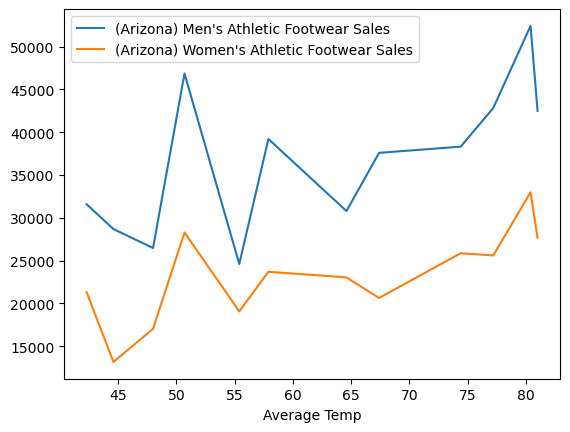

In [1237]:
fig, ax = plt.subplots()


arizona_merged.plot(ax=ax)
arizona_womens_merged.plot(ax=ax)

plt.show()